# Simulating LiteBIRD-like TOD with beamconv

This demo shows the functionalities of a simple simulation pipeline. The code, based on beamconv and DUCC, returns noisy TOD given an input map, LiteBIRD's scanning strategy, the focal plane specifics and the noise power spectrum. Any feedback is much appreciated!

### Preliminary steps
First, we import all the modules and libraries that we need. In particular:
- <b>beamconv</b> (<a href="https://github.com/AdriJD/beamconv">github.com/AdriJD/beamconv</a>) simulates the scanning of the CMB sky while incorporating realistic beams and scan strategies. This code uses (spin-)spherical harmonic representations of the (polarized) beam response and sky to generate simulated CMB detector signal timelines. Beams can be arbitrarily shaped. Optionally, the results can be binned on the sphere. The code makes use of qpoint, a lightweight quaternion-based library for telescope pointing (<a href="https://github.com/arahlin/qpoint">github.com/arahlin/qpoint</a>).
- <b>DUCC</b> (<a href="https://gitlab.mpcdf.mpg.de/mtr/ducc">gitlab.mpcdf.mpg.de/mtr/ducc</a>) is a collection of basic programming tools for numerical computation, including Fast Fourier Transforms, Spherical Harmonic Transforms, non-equispaced Fourier transforms, as well as some concrete applications like 4pi convolution on the sphere and gridding/degridding of radio interferometry data.
- <b>PySM</b> (<a href="https://arxiv.org/abs/1608.02841">arxiv.org/abs/1608.02841</a>) simulates maps of Galactic emission in intensity and polarization at microwave frequencies: synchrotron, thermal dust, free-free, and anomalous microwave emission over the whole sky, in addition to the CMB signal.

Also, we need to open LiteBIRD <b>IMO</b> database, which we need to read the noise's and focal plane's specifics from there.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

# BEAMCONV
from beamconv import ScanStrategy
import qpoint as qp

# DUCC
import ducc0

# PYSM
import pysm3
import pysm3.units as u

# LiteBIRD's IMO
import json
# opening IMO schema.json file and interpreting it as a dictionary
f = open('/afs/mpa/temp/monelli/litebird/litebird_imo-master/IMO/schema.json',)
data = json.load(f)  

# plot-related stuff
import copy
cmap_lighter = copy.copy(matplotlib.cm.get_cmap("YlOrBr_r"))
cmap_viridis = copy.copy(matplotlib.cm.get_cmap("viridis"))
cmap_magma = copy.copy(matplotlib.cm.get_cmap("magma"))

import warnings
warnings.filterwarnings("ignore")

import cycler

We need an input map, consisting of CMB signal and foregrounds. I obtained that by making use of <b>PySM 3</b>. The components simulated are: thermal dust, synchrotron, AME, free-free, and CMB.

In [2]:
%%capture
sky = pysm3.Sky(nside=128, preset_strings=["a1", "d1", "f1", "s1", "c1"], output_unit="uK_CMB")

Given the emission <code>sky</code>, the map for a given frequence (140 GHz) can be extracted:

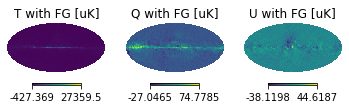

In [3]:
nu = 140 # since I'll be using the M1-140 channel
lmax = 256
map_FG = sky.get_emission(nu * u.GHz)
alm_FG = hp.map2alm(map_FG, lmax=lmax)

# plotting input maps
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
plt.axes(ax1)
hp.mollview(map_FG[0],title='T with FG [uK]', hold=True, cmap=cmap_viridis)
plt.axes(ax2)
hp.mollview(map_FG[1],title='Q with FG [uK]', hold=True, cmap=cmap_viridis)
plt.axes(ax3)
hp.mollview(map_FG[2],title='U with FG [uK]', hold=True, cmap=cmap_viridis)
plt.show()

Together with the <b>input maps</b>, we need to specify the <b>scanning strategy</b> and the <b>focal plane specifics</b>. Provided with that, beamconv is able to produce the TOD. 

### Reading the IMO
The IMO contains general information about the satellite, as well as the specifics of each detector. This script simulates the TOD measures by 4 detectors in the M1-140 channel. Let's see how to extract the information about them from the IMO.

Reading the info for all the detectors in the M1-140 channel.

In [4]:
# looking into the IMO, data['data_files'] is where the relevant info is stored 
data_files = data['data_files']

# counting how many objects are in the dictionary
nkey=0
for key in data_files:
    nkey = nkey+1

# looking for the detectors belonging to the M1-140 channel
for i in range(nkey):
    test = data_files[i]
    if(test['name'] == 'channel_info'):
        metadata = test['metadata']
        if(metadata['channel'] == 'M1-140'):
            detector_names = metadata['detector_names']
            break

ndet = len(detector_names)
det_indices = range(ndet)

print('the M1-140 channel has '+str(ndet)+' detectors')

list_of_dictionaries = []

# looking for the metadata of the detectors in detector_names
for d in detector_names:
    for j in range(nkey):
        test = data_files[j]
        if(test['name'] == 'detector_info'):
            metadata = test['metadata']
            if (metadata['name'] == d):
                list_of_dictionaries.append(metadata) # this list contains all the info about the M1-140 detectors
                break

the M1-140 channel has 366 detectors


In [5]:
# the following quantities are actually identical for each detector
fwhm = list_of_dictionaries[0]['fwhm_arcmin']
ellipticity = list_of_dictionaries[0]['ellipticity'] # it's zero, IS THIS REALISTIC?
bandcenter = list_of_dictionaries[0]['bandcenter_ghz']
bandwidth = list_of_dictionaries[0]['bandwidth_ghz']
sampling_freq = list_of_dictionaries[0]['sampling_rate_hz']
net = list_of_dictionaries[0]['net_ukrts']
pol_sensitivity = list_of_dictionaries[0]['pol_sensitivity_ukarcmin']
fknee = list_of_dictionaries[0]['fknee_mhz']
fmin = list_of_dictionaries[0]['fmin_hz']
alpha = list_of_dictionaries[0]['alpha']

# instead, the following change detector by detector
pol_array = np.empty(ndet, dtype=object)
orient_array = np.empty(ndet, dtype=object)
quat_array = np.empty((ndet,4))

for i in det_indices:
    pol_array[i] = list_of_dictionaries[i]['pol']
    orient_array[i] = list_of_dictionaries[i]['orient']
    quat_array[i] = np.array(list_of_dictionaries[i]['quat'])

According to the IMO documentation:
   - pol - The polarization of the detector (T/B). The default is None
   - orient - The orientation of the detector (Q/U). The default is None
   - quat - The quaternion expressing the rotation from the detector reference frame to the boresight reference frame. The default is no rotation at all, i.e., the detector is aligned with the boresight direction.

### Scanning strategy
Here I define a <code>ScanStrategy</code> object provided with an ideal HWP.

In [6]:
# setting up the scanning strategy parameters
ctime0 = 1510000000            # initial time
mlen = 1 * 24 * 60 * 60        # mission length in seconds (one day!)

# definition of the scanning strategy making use of LiteBIRD's specifics (with HWP)
ss_hwp = ScanStrategy(duration=mlen,
        external_pointing=True,
        theta_antisun = 45.,          # [deg]
        theta_boresight = 50.,        # [deg]
        freq_antisun = 192.348,       # [min]
        freq_boresight = 0.314,       # [rad/min]
        sample_rate = sampling_freq,  # [Hz]
        jitter_amp=0.0,
        ctime0=ctime0)

In order to generate a LiteBIRD-like scanning strategy, some functionalities of <b>pyScan</b> (<a href="https://github.com/tmatsumu/LB_SYSPL_updated">github.com/tmatsumu/LB_SYSPL_updated</a>) have been implemented in beamconv. In particular
- The <code>litebird_scan</code> function returns a quaternion that describes the boresight orientation (\theta, \phi and \psi angles) at any time sample;
- <code>litebird_ctime</code>, instead, produces unix time (<code>ctime</code>) for a given chunk.

In [7]:
# further options (with HWP)
scan_opts_hwp = dict(
        q_bore_func=ss_hwp.litebird_scan,
        ctime_func=ss_hwp.litebird_ctime,
        use_litebird_scan=True,
        q_bore_kwargs=dict(),
        ctime_kwargs=dict(),
        max_spin=2,
        nside_spin=128,
        preview_pointing=False,
        verbose=True,
        save_tod=True)

Last thing to set up is the partition of the mission in chunks.

In [8]:
# calculate TOD in 10 chunks
nchunk = 10
nsamp_chunk = int(ss_hwp.mlen * ss_hwp.fsamp / nchunk)
nsamp = int(ss_hwp.mlen * ss_hwp.fsamp)

chunks_hwp = ss_hwp.partition_mission(nsamp_chunk)

### Focal plane and beam specifics
We can specify the HWP features when defining the beam and creating the focal plane. In particular, the Mueller matrix can be set up in in beam options, while the HWP frequency can be specified with <code>set_hwp_mode</code>. Here I'm using the first 4 detectors of the M1-140 channel.

In [9]:
# create a grid of Gaussian beams
ndet = 4

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))
quats = np.zeros((ndet,2,4))

for i in range(ndet):
    quats[i,0,:] = list_of_dictionaries[2*i]['quat'] # the offset quaternions are taken from the IMO
    quats[i,1,:] = list_of_dictionaries[2*i]['quat'] # the offset quaternions are taken from the IMO
    if list_of_dictionaries[i]['orient'] == 'Q':
        if list_of_dictionaries[i]['pol'] == 'T':
            polangs[i,0] = 0
            polangs[i,1] = 0
        else:
            polangs[i,0] = 90
            polangs[i,1] = 90
    else: 
        if list_of_dictionaries[i]['pol'] == 'T':
            polangs[i,0] = 45
            polangs[i,1] = 45
        else:
            polangs[i,0] = 135
            polangs[i,1] = 135
            
deads = np.array([[0,1]]*ndet)  

# setting up the beam options
beam_opts_hwp = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=fwhm,          # gaussian co-pol beam, so only specify FWHM (arcmin)
                 hwp_mueller=np.diag([1, 1, -1, -1]),
                 quats=quats)

# defining HWP frequency
ss_hwp.set_hwp_mod(mode='continuous', freq=88/60)

# creating the focal plane
ss_hwp.input_focal_plane(azs, els, polangs, deads, combine=True, scatter=False, **beam_opts_hwp)

### Coverage maps
As a countercheck, let us produce the coverage map.

In [10]:
%%capture

# producing the coverage map
ss_hwp.allocate_maps(nside=128)
ss_hwp.scan_instrument_mpi(alm_FG, **scan_opts_hwp)
maps_hwp, cond, proj_hwp = ss_hwp.solve_for_map(return_proj = True)

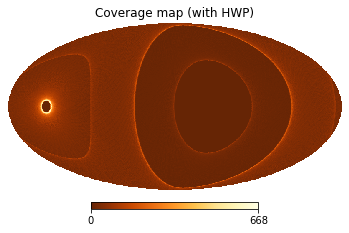

In [11]:
hp.mollview(proj_hwp[0],title='Coverage map (with HWP)', hold=True, cmap=cmap_lighter)
plt.show()

### Injecting noise
By making use of DUCC we can produce a noise realization, given its power spectrum in frequency. Tre numerical values are the one read in the IMO.

In [12]:
# parameters for generating noise with ducc0 P(f)=sigma^2[(f^2+f_knee^2)/(f^2+f_min^2)]^(slope/2)
sigma = net        # is it okay?
f_min = fmin
f_knee = fknee/1000
f_samp = sampling_freq
slope = -2*alpha   # is it okay?

The noiseless TOD are produced by beamconv for each chunk, to which we can add the noise.

In [13]:
# setting up and fillind TOD (noiseless, noisy and noise-only) 
noiseless_TOD_hwp = np.empty((ndet,nsamp))
noisy_TOD_hwp = np.empty((ndet,nsamp))
noise_TOD_hwp = np.empty((ndet,nsamp))

for det in range(ndet):
    gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, f_samp, slope)
    for chunk in range(nchunk):
        inp = np.random.normal(0.,1.,(nsamp_chunk,))
        noise = gen.filterGaussian(inp)
        #
        noiseless_data = ss_hwp.data(chunks_hwp[chunk],ss_hwp.beams[det][0],data_type='tod')
        noisy_data = noiseless_data + noise
        noiseless_TOD_hwp[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noiseless_data
        noisy_TOD_hwp[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noisy_data
        noise_TOD_hwp[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noise

As a countercheck, we can plot the noise power spectrum for a given detector.

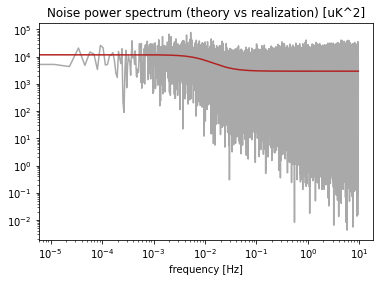

In [14]:
# Evaluating  and plotting the power spectrum
ps = np.abs(np.fft.fft(noise_TOD_hwp[0,:]))**2 / nsamp
time_step = 1. / f_samp
freqs = np.fft.fftfreq(noise_TOD_hwp[0,:].size, time_step)
ps_theory = sigma**2 * ((freqs**2+f_knee**2)/(freqs**2+f_min**2))**(-slope/2)

plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'darkgray')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'firebrick')
plt.title('Noise power spectrum (theory vs realization) [uK^2]')
plt.xlabel('frequency [Hz]')
plt.show()

Averaging 300 realizations of the noise, the power spectrum recovers the theoretical one.

In [15]:
ps = np.zeros(nsamp)
nps = int(300)

gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, f_samp, slope)

for i in range(nps):
    noise = np.zeros(nsamp)
    for chunk in range(nchunk):
        inp = np.random.normal(0.,1.,(nsamp_chunk,))
        #
        noise[chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = gen.filterGaussian(inp)
    ps += np.abs(np.fft.fft(noise))**2 / nsamp

ps = ps/nps

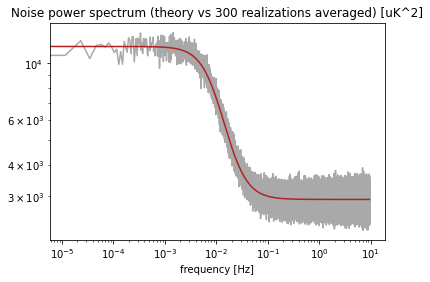

In [16]:
# Plotting the power spectrum
plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'darkgray')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'firebrick')
plt.title('Noise power spectrum (theory vs 300 realizations averaged) [uK^2]')
plt.xlabel('frequency [Hz]')
plt.show()

### Noisy TOD
 - The coverage maps look good;
 - The noise looks good;
 - The HWP behaves well (see <code>demo.ipynb</code>)
 
Let's finally take a look at the noisy TOD for the whole mission.

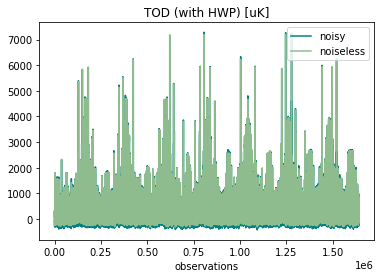

In [17]:
plt.plot(noisy_TOD_hwp[0,:],'teal',label='noisy')
plt.plot(noiseless_TOD_hwp[0,:],'darkseagreen',label='noiseless')
plt.legend(loc=1)
plt.title('TOD (with HWP) [uK]')
plt.xlabel('observations')
plt.show()

The noiseless TOD seem to be "periodic". This actually makes sense, since the "period" correspond to a precession period.

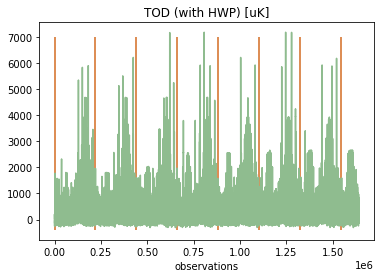

In [18]:
prec_idx = int(3.2058 * 60 * 60 * 19.1)

plt.plot(noiseless_TOD_hwp[0,:],'darkseagreen')
plt.vlines(0*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(1*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(2*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(3*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(4*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(5*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(6*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(7*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.title('TOD (with HWP) [uK]')
plt.xlabel('observations')
plt.show()

## Steps further
- Include HWP non-idealities
- More realistic beam shapes
- Include the dipole (time-dependent in particular)
- Adapt this for production purposes (what does the collaboration need? which format?)

In [19]:
# alm coefficients for the static dipole
#alm[0,hp.sphtfunc.Alm.getidx(lmax,1,0)] = 5.124              # Adding the static dipole (a_10)
#alm[0,hp.sphtfunc.Alm.getidx(lmax,1,1)] = (0.3384 - 3.215j)  # Adding the static dipole (a_11)